#**Building a Convolutional Neural Network Model to Identify the American Sign Language (ASL): Is it a sign?**

#### By Pinyapat Manasboonpermpool, Stella Säfström and Vendela Meyerhöffer

## Introduction

The American Sign Language (ASL) database of hand gestures consists of 24 letters. All letters of the English alphabet are present, except for the letter (J=9) and (Z=25), due to that these letters require hand motions. In this project, we aim to classify the 24 available letters using convolutional neural networks (CNN) to identify a sign language. The dataset present us with a multiclass classification problem that is suitable for convolutional neural networks.

The data consists of 27,455 training cases and 7,172 test cases. The data set is similar to MNIST with a header row for the label and all pixel values ranging from pixel1 to pixel784. These values represent a single 28x28 pixel image in grayscale (thus with values between 0 - 255).

In this report, we aim at correctly classifying the 24 labels (hand gestures/ letters) by building a suitable convolutional neural network. Throughout the project we are continously tweaking and changing the model to improve the test accuracy. This is an interesting problem, seeing as it could improve the communication between deaf and hard-of-hearing through computer vision applications.

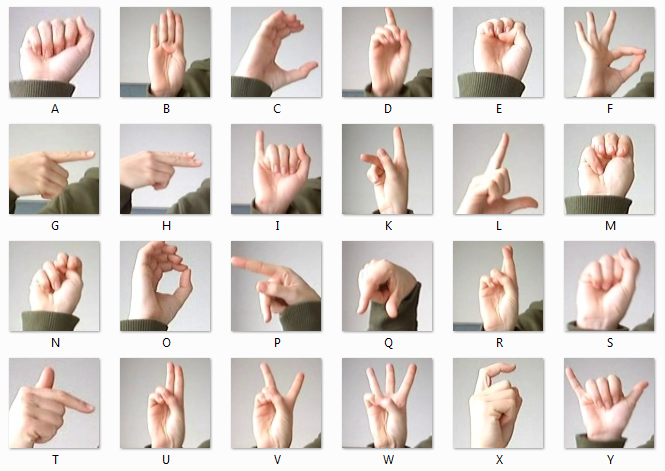

##Method

### Convolutional Neural Networks
 
Convolutional neural networks (CNN) are a special type of neural networks that work especially well in image recognition. In very simple terms, convolutional neural networks are able to identify local features in images, which are combined to output a classification. The first layers of a convolutional neural network are often able to identify low-level features such as edges, circles and shapes. In the next layers more complex features such as eyes, fur and teeth are identified. By doing so the network can output a classification. 
 
The model is able to classify images by using convolutional layers and pooling layers. Convolutional layers search for features and patterns in the images. The layer consists of many convolutional filters (also known as feature detectors) which determine if there is a certain feature in an image. This is done by convolutions. We will not go into the mathematical details of how this works.
 
The pooling layer condenses large images into smaller versions that summarize its information. The max pooling layer (which we choose to use in this project) does this by taking the maximum valued pixel in each non-overlapping 2x2 block in the image.

We can choose how many convolutional and pooling layers we see fit for our model. There are also several tuning parameters to take into account. We can for instance use dropout learning and regularization methods. In this project we will attempt to tweak and tune a basic CNN model in order to reduce the test loss as much as possible.

(Source: An Introduction to Statistical Learning, 2021)





## Analysis

### Importing the libraries
We begin this project by loading all the necessary libraries for the analysis. 

In [ ]:
# Use seaborn for pairplot
!pip install -q seaborn

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import math

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print(tf.__version__)

2.8.0


##Exploring the data

We start the analysis by loading the sign mnist data into the working directory. The data has already been divided into training and test data sets, so there is no need for us to divide the data ourselves.

In [ ]:
#Load Data
sign_lang_train = pd.read_csv("sign_mnist_train.csv")
sign_lang_test = pd.read_csv("sign_mnist_test.csv")

Next, we take a look at the data types in our training data. We can see that we have one label and 784 pixel values.

In [ ]:
#Explore the type of the data
sign_lang_train.dtypes

label       int64
pixel1      int64
pixel2      int64
pixel3      int64
pixel4      int64
            ...  
pixel780    int64
pixel781    int64
pixel782    int64
pixel783    int64
pixel784    int64
Length: 785, dtype: object

In [ ]:
#Observe the training data (27455 , 785)
print(sign_lang_train.head(-5)) 
sign_lang_train.shape

       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          3     107     118     127     134     139     143     146     150   
1          6     155     157     156     156     156     157     156     158   
2          2     187     188     188     187     187     186     187     188   
3          2     211     211     212     212     211     210     211     210   
4         13     164     167     170     172     176     179     180     184   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
27445     14     167     169     170     171     171     172     172     172   
27446     19     133     135     138     141     143     144     144     145   
27447     11     170     172     175     177     179     182     185     186   
27448     12     149     151     153     157     159     161     164     165   
27449     20     162     168     172     176     179     183     184     185   

       pixel9  ...  pixel775  pixel776 

(27455, 785)

In [ ]:
#Observe the test data (7172 , 785)
print(sign_lang_test.head(-5)) 
sign_lang_test.shape

      label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0         6     149     149     150     150     150     151     151     150   
1         5     126     128     131     132     133     134     135     135   
2        10      85      88      92      96     105     123     135     143   
3         0     203     205     207     206     207     209     210     209   
4         3     188     191     193     195     199     201     202     203   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
7162     10     130     131     131     134     133     135     137     136   
7163      4     158     161     165     169     172     175     177     179   
7164     14     141     144     146     149     153     156     158     161   
7165      8     158     160     160     161     161     161     164     162   
7166     12     169     173     177     181     183     186     189     191   

      pixel9  ...  pixel775  pixel776  pixel777  pi

(7172, 785)

### Shuffle the training data

We then shuffle the training data to reduce any variances and that they can represent the overall distribution of the data before building the CNN model. 

In [ ]:
sign_lang_train = sign_lang_train.sample(frac = 1)
sign_lang_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
13049,18,191,193,195,198,200,201,204,205,206,...,206,246,239,241,241,242,242,242,242,242
25786,4,194,194,196,197,198,198,199,199,198,...,18,3,195,252,237,238,237,236,236,236
2372,12,175,176,176,176,175,176,177,174,173,...,205,202,202,201,201,199,197,196,194,193
13225,2,173,174,173,173,174,174,174,173,173,...,217,216,216,215,215,214,212,211,196,166
3578,22,101,117,131,139,142,147,155,159,165,...,110,106,107,81,46,43,30,27,31,29


In order to get a better grasp of the data, we plot a histogram to see the overall distribution from both train and test labels.

As one can see, each training label is considered to be well-balanced which indicates that there are adequate training examples to build a model. Apart from this, the test label appears to be perfect for further evaluation on a model due to its unbalanced distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


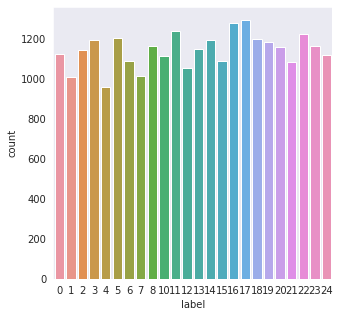

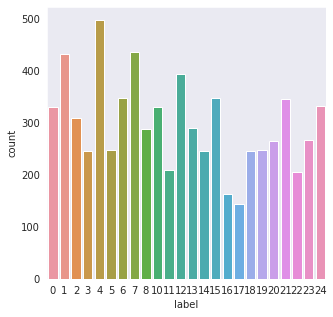

In [ ]:
plt.figure(figsize = (5,5)) # Label Count for Train, quiet well distributed
sns.set_style("dark")
sns.countplot(sign_lang_train['label'])

plt.figure(figsize = (5,5)) # Label for Test, quiet unbalanced
sns.set_style("dark")
sns.countplot(sign_lang_test['label'])

In [ ]:
#Unique to find out the total numbers of layers 
labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
unique_val = sign_lang_train['label']
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

# **Data Transformation**

In order to perform CNN, we need to normalize, reshape and encode the labels to so called one hot vectors.

### One-Hot Encoding

We begin by converting the labels into one-hot vectors. If we fail to do this, the model can incorrectly assume that there is an ordinal relationship between the labels. This can result in poor performance of our model. Therefore, we convert the labels into one hot vectors as seen below using the label binarizer function.

In [ ]:
#Extracting y, i.e. the label values
y_train = sign_lang_train['label'].values
y_test = sign_lang_test['label'].values

print(y_train)

[18  4 12 ... 19 21  4]


In [ ]:
#Binary Classifer / One hot encoding

from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

print(y_train)
print(y_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [ ]:
#Number of labels
num_labels = y_train.shape[1]
print(f"There are {num_labels} labels in the dataset")

There are 24 labels in the dataset


### Normalization and reshaping

Next, we normalize the training and test data. We do this in order to make the algorithm converge faster. 

Simultaneously we reshape the data into 28x28x1 matrices. 



In [ ]:
#Construct x_train and x_test
x_train = sign_lang_train.drop(columns = ['label']).to_numpy().reshape((sign_lang_train.shape[0], 28, 28,1)).astype('float64')/255.0
x_test = sign_lang_test.drop(columns = ['label']).to_numpy().reshape((sign_lang_test.shape[0], 28,28,1)).astype('float64')/255.0

x_train.shape

(27455, 28, 28, 1)

We can also take a look at some examples of pictures in the data. 

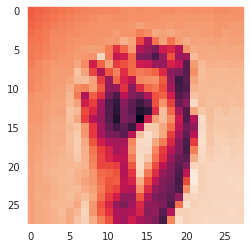

In [ ]:
plt.imshow(x_train[0].reshape(28,28))

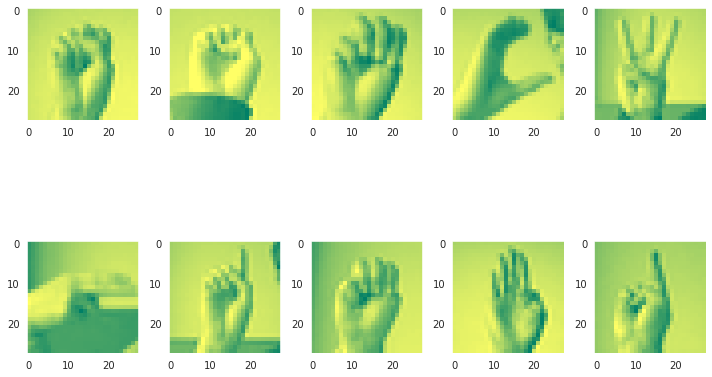

In [ ]:
#Overview of images
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
z = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[z].reshape(28, 28) , cmap = "summer")
        z += 1
    plt.tight_layout() 

# **Building Convolutional Models**

### Designing the model
After exploring and pre-processing the data, we are now ready to start designing our Convolutional Neural Network. Below we are building seven models with different tweaks and changes, aiming to find a model that performs the best in terms of validation accuracy (computed on the test data). 

We are starting with a rather basic CNN model with two convolutional layers (`tf.keras.layers.Conv2D`) and 128 neurons in the output layer (`tf.keras.layers.Dense`). The nodes in the output layer is equal to the number of labels (*y*) and hence the number of signs. 

Apart from this we apply the keras layer `tf.keras.layers.MaxPooling2D` to the network. Max pooling reduces dimensionality in our data, which also helps to control overfitting. It also makes feature detection scale and orientation invariant. 

We use ReLU as activation function in the hidden layers and softmax in the ouput layer, due to that we want to perform a multiclass classification.

Below the code block, there is a printed summary of the model to show a better overview of the structure of the model in terms of number of parameters and in which layer these are found. 

In [ ]:
#Design network: setting and building the model with 128-neuron (first try)
model = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

### Compiling the model
Before training the model, it need to be compiled using an optimizer, specifying a loss function and a metrics. For the latter we use 'accuracy' in order to monitor the extent of which the model predicts images correctly, measured in percentage. 

The loss function used is categorical cross entropy, which is used when we want to do a multiclass classification. 

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training the model
In the next step, we train the model by calling `.fit()` which iterate over the entire set of data for a given number of epochs. We have chosen 10 epochs to start off with, however this is a hyperparameter of gradient descent so it might need to be tuned. In general, using more than ten epochs will improve the accuracy since the model then has more iterations to adjust the parameters, and hence, to learn from the data. However, adding epochs is computationally costly so there is always a question of balance between performance and cost. 

The full test data is used as validation data, in order to monitor validation loss at the end of each epoch. 

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    epochs = 10, 
    validation_data = (x_test, y_test)) 

Epoch 1/10
858/858 [==============================] - 49s 55ms/step - loss: 0.7953 - accuracy: 0.7665 - val_loss: 0.3677 - val_accuracy: 0.8827
Epoch 2/10
858/858 [==============================] - 39s 46ms/step - loss: 0.0368 - accuracy: 0.9926 - val_loss: 0.3203 - val_accuracy: 0.9162
Epoch 3/10
858/858 [==============================] - 40s 47ms/step - loss: 0.0050 - accuracy: 0.9995 - val_loss: 0.3599 - val_accuracy: 0.9162
Epoch 4/10
858/858 [==============================] - 39s 46ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.3149 - val_accuracy: 0.9240
Epoch 5/10
858/858 [==============================] - 40s 47ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.3390 - val_accuracy: 0.9250
Epoch 6/10
858/858 [==============================] - 39s 45ms/step - loss: 2.7522e-04 - accuracy: 1.0000 - val_loss: 0.3734 - val_accuracy: 0.9235
Epoch 7/10
858/858 [==============================] - 39s 45ms/step - loss: 1.6269e-04 - accuracy: 1.0000 - val_loss: 0.3629 - val_a

###Evaluating the model
By then calling `.evaluate()` we can see how well the model performed on the test data in terms of loss and accuracy. As stated below, the validation accuracy is 92.71 %.

In [ ]:
print("The accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 12ms/step - loss: 0.4256 - accuracy: 0.9271
The accuracy of the model is -  92.70775318145752 %


###Plotting accuracy and loss
We can now plot the training and validation accuracy (left) as well as the training and validation loss (right) to create a visual presentation of how it evolves over the number of epochs.  

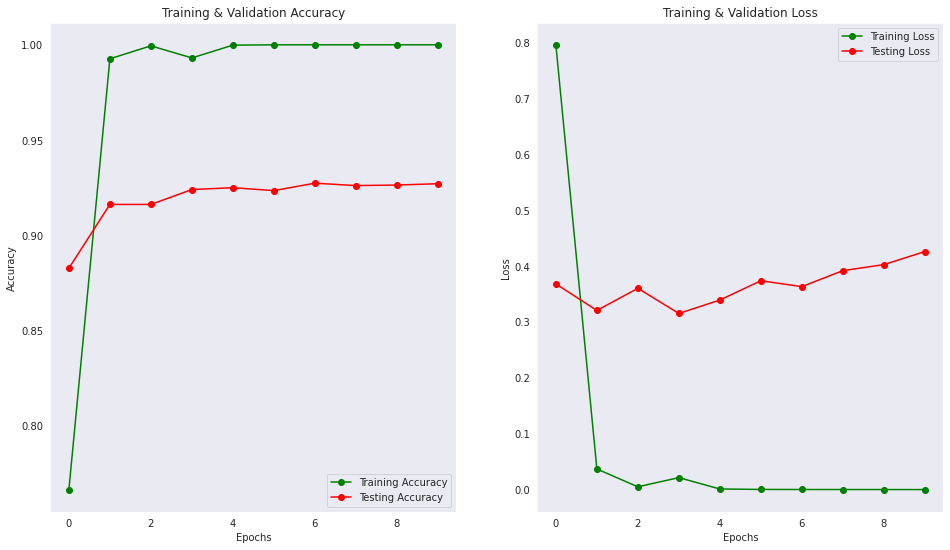

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

##Overfitting

Looking at the graphs above, we can see that the model is clearly overfitting. The testing accuracy is well below the training accuracy. When looking at the loss, we can see a huge difference. The loss in the test data is over 35 % while the training loss is close to 0. We can see that we need to makes some changes in our model in order to combat this problem.

###Adding batch size
In order to try to prevent the overfitting and hence improve the validation accuracy, we specify a `batch_size` inside the `.fit()` call. This is a hyperparameter of gradient descent, splitting the data into a set of mini-batches and regulates the number of training samples to iterate over before updating the model parameters. This is not to confuse with epochs, which controls the number of **complete** passes through the training dataset. 

Popular batch sizes include samples of 32, 64 and 128. To begin with, we are trying with a batch size of 32: 

In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_test, y_test)) 

Epoch 1/10
858/858 [==============================] - 39s 45ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 0.3933 - val_accuracy: 0.9102
Epoch 2/10
858/858 [==============================] - 39s 45ms/step - loss: 3.8179e-04 - accuracy: 1.0000 - val_loss: 0.4301 - val_accuracy: 0.9130
Epoch 3/10
858/858 [==============================] - 39s 45ms/step - loss: 1.6216e-04 - accuracy: 1.0000 - val_loss: 0.4349 - val_accuracy: 0.9109
Epoch 4/10
858/858 [==============================] - 39s 45ms/step - loss: 9.1778e-05 - accuracy: 1.0000 - val_loss: 0.4497 - val_accuracy: 0.9124
Epoch 5/10
858/858 [==============================] - 39s 45ms/step - loss: 5.7626e-05 - accuracy: 1.0000 - val_loss: 0.4620 - val_accuracy: 0.9096
Epoch 6/10
858/858 [==============================] - 39s 45ms/step - loss: 3.7798e-05 - accuracy: 1.0000 - val_loss: 0.4719 - val_accuracy: 0.9109
Epoch 7/10
858/858 [==============================] - 39s 46ms/step - loss: 2.4448e-05 - accuracy: 1.0000 - val_loss

In [ ]:
print("The accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 3s 12ms/step - loss: 0.3726 - accuracy: 0.9202
The accuracy of the model is -  92.02454090118408 %


Since specifying a batch size of 32 slightly improves the accuracy from 92.71% to 92.02%, there was no difference. Thus, we are increasing it to the size of 64 to see the performance:

In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_data = (x_test, y_test)) 

Epoch 1/10
429/429 [==============================] - 36s 84ms/step - loss: 1.0850e-04 - accuracy: 1.0000 - val_loss: 0.3535 - val_accuracy: 0.9253
Epoch 2/10
429/429 [==============================] - 37s 86ms/step - loss: 6.9990e-05 - accuracy: 1.0000 - val_loss: 0.3555 - val_accuracy: 0.9274
Epoch 3/10
429/429 [==============================] - 37s 86ms/step - loss: 5.2147e-05 - accuracy: 1.0000 - val_loss: 0.3589 - val_accuracy: 0.9272
Epoch 4/10
429/429 [==============================] - 37s 85ms/step - loss: 4.0344e-05 - accuracy: 1.0000 - val_loss: 0.3593 - val_accuracy: 0.9286
Epoch 5/10
429/429 [==============================] - 37s 86ms/step - loss: 3.2041e-05 - accuracy: 1.0000 - val_loss: 0.3652 - val_accuracy: 0.9288
Epoch 6/10
429/429 [==============================] - 37s 85ms/step - loss: 2.5548e-05 - accuracy: 1.0000 - val_loss: 0.3721 - val_accuracy: 0.9313
Epoch 7/10
429/429 [==============================] - 36s 85ms/step - loss: 2.0613e-05 - accuracy: 1.0000 - val_

In [ ]:
print("The accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 12ms/step - loss: 0.3873 - accuracy: 0.9340
The accuracy of the model is -  93.40490698814392 %


This gave some improvement! The validation accuracy increased from 92.02 % to 93.40 %. Let's try with a batch size of 128:

In [ ]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_test, y_test)) 

Epoch 1/10
215/215 [==============================] - 33s 152ms/step - loss: 9.2381e-06 - accuracy: 1.0000 - val_loss: 0.3907 - val_accuracy: 0.9343
Epoch 2/10
215/215 [==============================] - 33s 154ms/step - loss: 8.2915e-06 - accuracy: 1.0000 - val_loss: 0.3935 - val_accuracy: 0.9342
Epoch 3/10
215/215 [==============================] - 33s 152ms/step - loss: 7.5287e-06 - accuracy: 1.0000 - val_loss: 0.3963 - val_accuracy: 0.9339
Epoch 4/10
215/215 [==============================] - 33s 152ms/step - loss: 6.7657e-06 - accuracy: 1.0000 - val_loss: 0.3989 - val_accuracy: 0.9346
Epoch 5/10
215/215 [==============================] - 33s 152ms/step - loss: 6.1312e-06 - accuracy: 1.0000 - val_loss: 0.4007 - val_accuracy: 0.9353
Epoch 6/10
215/215 [==============================] - 33s 154ms/step - loss: 5.5080e-06 - accuracy: 1.0000 - val_loss: 0.4030 - val_accuracy: 0.9345
Epoch 7/10
215/215 [==============================] - 33s 151ms/step - loss: 4.9842e-06 - accuracy: 1.0000

####Conclusion: Batch size
When trying with three different batch sizes (32, 64 and 128), a batch size of 128 generated the best validation accuracy of 93.42 %. We will hence use this setting when moving forward with building the model. 

###Increasing number of neurons
We will now build a similar CNN model, however with an increased number of neurons in the output layer. We are now setting them to the maximum value of 512 in order to increase the depth of the neural network. We are then repeating the same steps as for the previous model in order to obtain the validation accuracy. 

In [ ]:
model1 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [ ]:
history1 = model1.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_test, y_test))

Epoch 1/10
215/215 [==============================] - 40s 187ms/step - loss: 2.1665e-04 - accuracy: 1.0000 - val_loss: 0.4489 - val_accuracy: 0.8988
Epoch 2/10
215/215 [==============================] - 40s 185ms/step - loss: 1.6753e-04 - accuracy: 1.0000 - val_loss: 0.4456 - val_accuracy: 0.9025
Epoch 3/10
215/215 [==============================] - 40s 185ms/step - loss: 1.3831e-04 - accuracy: 1.0000 - val_loss: 0.4501 - val_accuracy: 0.9028
Epoch 4/10
215/215 [==============================] - 40s 186ms/step - loss: 1.0924e-04 - accuracy: 1.0000 - val_loss: 0.4569 - val_accuracy: 0.8989
Epoch 5/10
215/215 [==============================] - 39s 184ms/step - loss: 9.4701e-05 - accuracy: 1.0000 - val_loss: 0.4772 - val_accuracy: 0.9002
Epoch 6/10
215/215 [==============================] - 39s 184ms/step - loss: 7.7794e-05 - accuracy: 1.0000 - val_loss: 0.4695 - val_accuracy: 0.9006
Epoch 7/10
215/215 [==============================] - 40s 186ms/step - loss: 6.3381e-05 - accuracy: 1.0000

In [ ]:
print("Accuracy of the model 1 is - " , model1.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 6s 28ms/step - loss: 0.5015 - accuracy: 0.9017
Accuracy of the model 1 is -  90.1701033115387 %


####Conclusion: Increasing neurons
Increasing the neurons from 128 to 512 does not result in a higher validation accuracy. However, it might increase only the depth of the neural network. We noticed that the result is remained high although it appears the overfitting. Then, we will keep this setting when proceeding with the next model when applying regularization methods to prevent overfitting. 


###Adding Batch Normalization layer and controlling learning rate
In the following model, we are using the keras layer `tf.keras.layers.BatchNormalization()` to our existing convolutional layers. This normalizes the inputs by applying a transformation that will keep the mean output close to zero and the output standard deviation close to 1. 

Additionally, before training the model, we are specifying a reduced learning rate in order to keep the model from learning patterns in the data too quickly, and hence, to prevent overfitting. The reduced learning rate is added into the `.fit()` call using the `callbacks` input. 

Again, we are repeating the steps of compiling, training and evaluating the model in order to obtain the validation accuracy. 

In [ ]:
model2 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

Before applying the learning rate, we observed the performance without the learning but applied only the batch normalization in the network in order to first see what this does to the performance. 

In [ ]:
history2_nolr = model2.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_test, y_test)) #93.43

Epoch 1/10
215/215 [==============================] - 54s 247ms/step - loss: 0.3376 - accuracy: 0.9255 - val_loss: 8.7135 - val_accuracy: 0.0371
Epoch 2/10
215/215 [==============================] - 53s 247ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.4114 - val_accuracy: 0.2945
Epoch 3/10
215/215 [==============================] - 53s 248ms/step - loss: 4.5291e-04 - accuracy: 1.0000 - val_loss: 0.2749 - val_accuracy: 0.9170
Epoch 4/10
215/215 [==============================] - 53s 246ms/step - loss: 2.3276e-04 - accuracy: 1.0000 - val_loss: 0.2825 - val_accuracy: 0.9304
Epoch 5/10
215/215 [==============================] - 53s 249ms/step - loss: 1.2934e-04 - accuracy: 1.0000 - val_loss: 0.2944 - val_accuracy: 0.9329
Epoch 6/10
215/215 [==============================] - 54s 249ms/step - loss: 8.0065e-05 - accuracy: 1.0000 - val_loss: 0.3102 - val_accuracy: 0.9313
Epoch 7/10
215/215 [==============================] - 54s 252ms/step - loss: 5.3326e-05 - accuracy: 1.0000 - val_l

The result appears that there was some improvement which next we will apply the learning rate to see whether the accuracy can be enhanced. 

Reduce learning rate is applied to assist a metric has stopped improving. This part we experiment by monitoring the validation accuracy.

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
history2 = model2.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 58s 271ms/step - loss: 1.6763e-05 - accuracy: 1.0000 - val_loss: 0.3363 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 56s 263ms/step - loss: 1.3562e-05 - accuracy: 1.0000 - val_loss: 0.3443 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 55s 258ms/step - loss: 1.0863e-05 - accuracy: 1.0000 - val_loss: 0.3552 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 55s 255ms/step - loss: 8.8122e-06 - accuracy: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 56s 259ms/step - loss: 7.3662e-06 - accuracy: 1.0000 - val_loss: 0.3591 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 56s 258ms/step - loss: 6.1378e-06 - accuracy: 1.0000 - val_loss: 0.3628 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 7/10
215/215 [========

In [ ]:
print("Accuracy of the model 2 is - " , model2.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 5s 23ms/step - loss: 0.3761 - accuracy: 0.9403
Accuracy of the model 2 is -  94.03234720230103 %


####Conclusion: Learning rate
It turns out that the decreased learning rate is improving the performance to the model providing the accuracy at 94.03%. 

###Adding drop out (Regurarization)
Overfitting is an unneglectable problem in deep CNNs, which can be effectively reduced by regularization. Then, we introduce some effective regularization technique: Dropout.

For our next model, we will try to improve the validation accuracy further by adding the keras layer `tf.keras.layers.Dropout()`. Drop out is a regularization technique to handle overfitting, where random neurons are "ignored" during the training process. As a result, the other neurons have to make up for the (temporarily) missing neurons, which makes the network become less sensitive to the specific weights of neurons. In this case, dropout is implemented by randomly selecting nodes to be dropped-out with a given probability of 20% each weight update cycle.

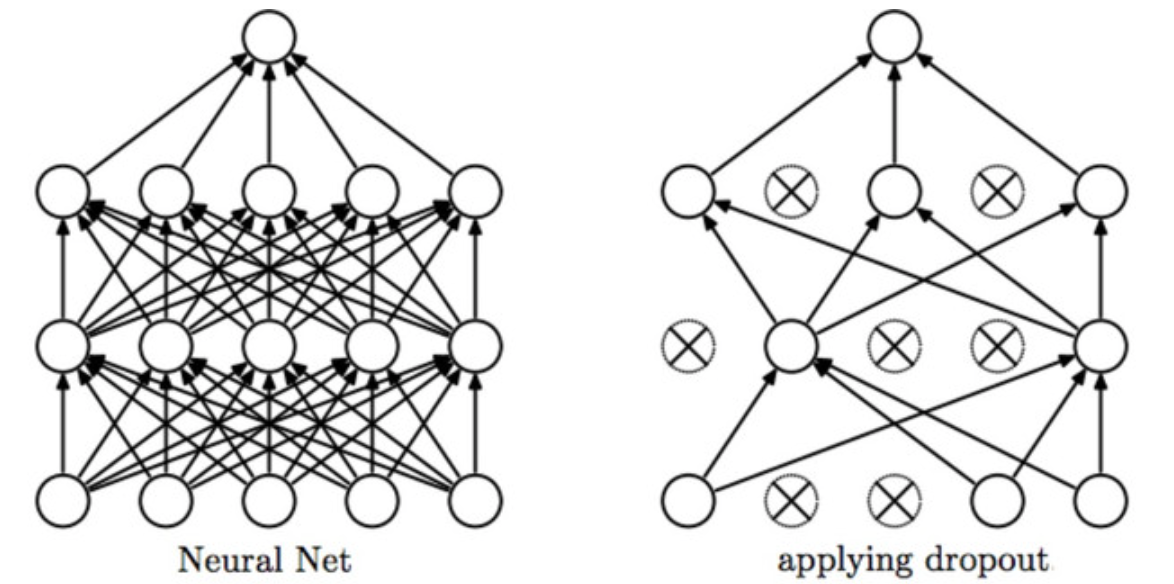

---



In [ ]:
model3 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
history3 = model3.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 56s 256ms/step - loss: 0.3388 - accuracy: 0.9091 - val_loss: 6.7984 - val_accuracy: 0.0574 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 57s 264ms/step - loss: 0.0059 - accuracy: 0.9991 - val_loss: 4.1397 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 54s 251ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.3638 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 54s 253ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.4609 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 54s 250ms/step - loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.4931 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9947
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [=============================

In [ ]:
print("Accuracy of the model 3 is - " , model3.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 4s 19ms/step - loss: 0.3328 - accuracy: 0.9374
Accuracy of the model 3 is -  93.7395453453064 %


####Conclusion: Drop out
We can see that using the drop put technique on the output layer is not improving the validation accuracy. However, we next will remain this regularization and apply further the optimization method such as data augmentation.

### Data Augmentation (Optimization)
Data augmentation consists in transforming the available data into new data without altering their natures.

As sometimes, the Neural Network model may memorize the images in the training set and may not be able to recognize the input of the test set. Data augmentation is one of the methods to prevent the overfitting as it can transform by many features such as sampling, mirroring, flipping, translation, rotation, changing brightness, adding noises etc. to make the images more generalized as some new images. As a result, our model can learn to understand the images from the training set and apply to any new sets rather than memorizing. 

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
          featurewise_center=False, 
          samplewise_center=False,
          featurewise_std_normalization=False, 
          samplewise_std_normalization=False,
          zca_whitening=False, 
          rotation_range= 10, 
          width_shift_range=0.0,
          height_shift_range=0.0, 
          brightness_range=None, 
          shear_range=0.0, 
          zoom_range=0.1, 
          fill_mode='nearest', 
          horizontal_flip=False, vertical_flip=False
)

datagen.fit(x_train)

In [ ]:
model4 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                      

In [ ]:
history4 = model4.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 10, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 61s 281ms/step - loss: 0.5721 - accuracy: 0.8384 - val_loss: 5.4980 - val_accuracy: 0.0682 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 62s 286ms/step - loss: 0.0449 - accuracy: 0.9863 - val_loss: 1.8353 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 60s 278ms/step - loss: 0.0260 - accuracy: 0.9915 - val_loss: 0.1952 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 60s 277ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.2473 - val_accuracy: 0.9407 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9964
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 60s 277ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.3459 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 6/10
215/215 [=============================

In [ ]:
print("Accuracy of the model 4 is - " , model4.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 5s 22ms/step - loss: 0.2261 - accuracy: 0.9564
Accuracy of the model 4 is -  95.63580751419067 %


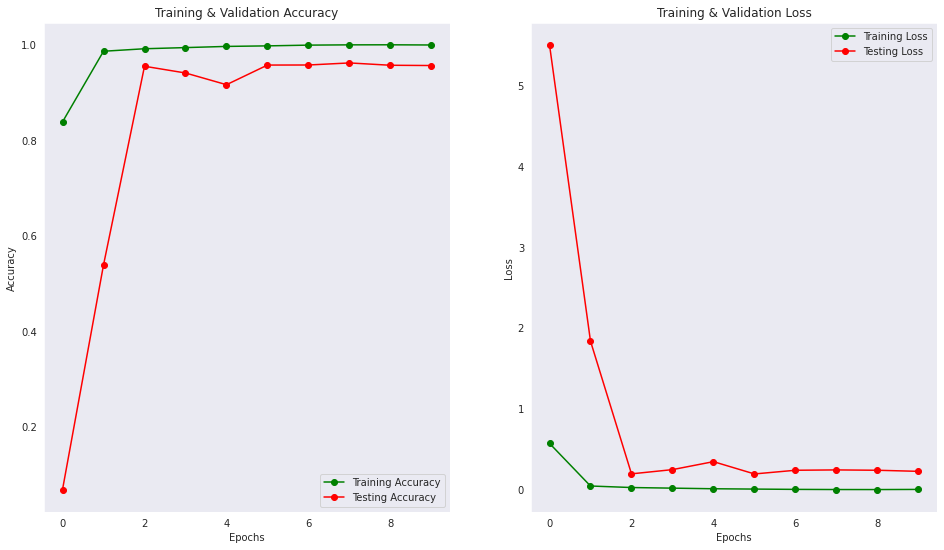

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history4.history['accuracy']
train_loss = history4.history['loss']
val_acc = history4.history['val_accuracy']
val_loss = history4.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

####Conclusion: Data Augmentation
As a result of applying data augmentation, the accuracy is further improved. Hence, we will keep this setting when building the next model. 

###Adjusting the Learning Rate

Next, we aim to monitor the loss rather than the accuracy and set the model as min so that the learning rate is reduced when the quantiy of loss monitored has stopped, min_delta for the threshold for measuring the new optimum and focus on purely significant changes, verboose to 1 to updat the messages, factor by which the learning rate will be reduced by and the min_lr to set the lower bound on the learning rate.

All these, we aim to see the increase of performance accuracy.

In [ ]:
#Change the learning rate to monitor loss
learning_rate_reduction_new = ReduceLROnPlateau(monitor='loss', mode = min, min_delta=0.01, patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
#Test with new adjustment of learning rate (new) and add drop out
model5 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # Output layer 
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 64)      

In [ ]:
history5 = model5.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 10, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction_new])

Epoch 1/10
215/215 [==============================] - 64s 288ms/step - loss: 0.7762 - accuracy: 0.7738 - val_loss: 5.2764 - val_accuracy: 0.0771 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 62s 288ms/step - loss: 0.0886 - accuracy: 0.9706 - val_loss: 0.9793 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 63s 292ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.2500 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 63s 293ms/step - loss: 0.0280 - accuracy: 0.9914 - val_loss: 0.3767 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 62s 290ms/step - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.1868 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 62s 290ms/step - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.2476 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 7/10
215/215 [==============================] 

In [ ]:
print("Accuracy of the model 5 is - " , model5.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 4s 18ms/step - loss: 0.1436 - accuracy: 0.9644
Accuracy of the model 5 is -  96.44450545310974 %


####Conclusion: New Reduced Learning Rate
As a result of applying the new reduced learning rate, the accuracy is further improved. Hence, we will keep this setting when building the next model. 

###Increasing the number of Epochs
After having tried different methods and, by doing so, have managed to increace the validation accuracy, we will now increase the number of epochs to see if this can improve the accuracy further since, as mentioned before, the model has then more iterations to adjust the parameters, and hence, to learn from the data. Since adding more epochs is costly, we have chosen to use a lower number of epochs up until now which has given us time to focus on the tweeks. 

Note that too many epochs can also cause overfitting so we should not put it too high. 

In [ ]:
# Adding epochs to 20 to see the performance of accuracy
model6 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    # Layer 2
    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_15 (Bat  (None, 14, 14, 64)      

In [ ]:
history6 = model6.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction_new])

Epoch 1/20
215/215 [==============================] - 66s 301ms/step - loss: 0.8574 - accuracy: 0.7597 - val_loss: 14.6408 - val_accuracy: 0.0462 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 62s 286ms/step - loss: 0.0852 - accuracy: 0.9725 - val_loss: 4.9014 - val_accuracy: 0.3009 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 63s 291ms/step - loss: 0.0427 - accuracy: 0.9863 - val_loss: 0.2010 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 63s 292ms/step - loss: 0.0244 - accuracy: 0.9919 - val_loss: 0.2154 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 62s 288ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.2607 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9920
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [============================

In [ ]:
print("Accuracy of the model 6 is - " , model6.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 7s 30ms/step - loss: 0.2035 - accuracy: 0.9668
Accuracy of the model 6 is -  96.68154120445251 %


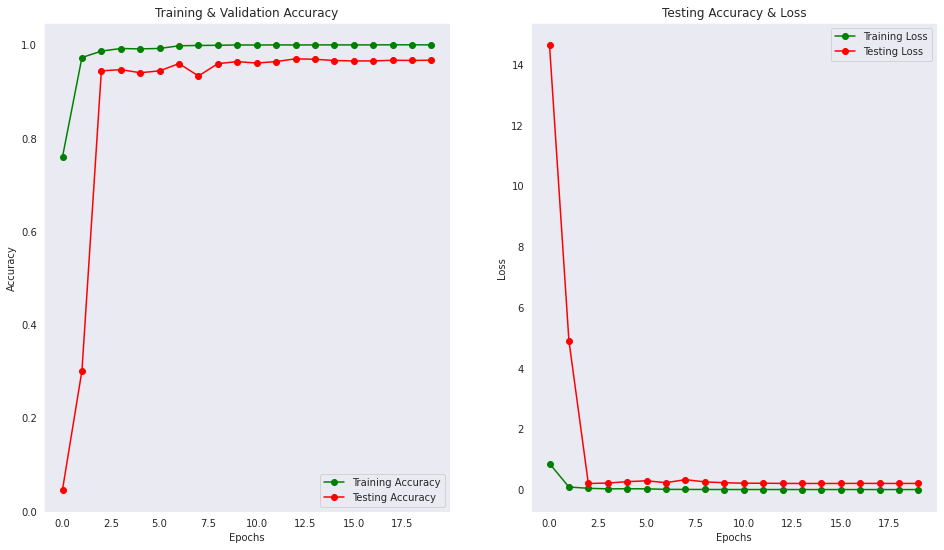

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history6.history['accuracy']
train_loss = history6.history['loss']
val_acc = history6.history['val_accuracy']
val_loss = history6.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

####Conclusion: Epochs
As expected, increasing the number of epochs resulted in an improved accuracy (quite significantly even). 

###Redesigning the model
In our next model, we are redesigning the CNN model by adding another convolutional layer in order to, again, try to improve the accuracy. As with epochs, adding another layer is costly, and thus, we have chosen to work with a simpler model up until now in order to save time. 

In [ ]:
# Redesign to see the performance of accuracy
model7 = tf.keras.models.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(75, (3,3), padding = 'same', input_shape = x_train[0].shape, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    # Layer 2
    tf.keras.layers.Conv2D(50 , (3,3), padding = 'same' , activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2,2), strides=2), #added
    # Layer 3
    tf.keras.layers.Conv2D(25, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    # Output layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_labels, activation = 'softmax')
])
model7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 75)        750       
                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 75)       300       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 75)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 50)        33800     
                                                                 
 dropout_13 (Dropout)        (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 50)       

In [ ]:
history7 = model7.fit(datagen.flow(x_train,y_train, batch_size = 128), epochs = 20, validation_data = (x_test, y_test), callbacks = [learning_rate_reduction_new])

Epoch 1/20
215/215 [==============================] - 114s 528ms/step - loss: 0.9366 - accuracy: 0.7043 - val_loss: 2.9656 - val_accuracy: 0.1115 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 112s 519ms/step - loss: 0.1632 - accuracy: 0.9452 - val_loss: 1.0557 - val_accuracy: 0.6535 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 111s 515ms/step - loss: 0.0757 - accuracy: 0.9758 - val_loss: 0.1803 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 116s 542ms/step - loss: 0.0525 - accuracy: 0.9827 - val_loss: 0.1738 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 112s 520ms/step - loss: 0.0417 - accuracy: 0.9861 - val_loss: 0.2405 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 112s 520ms/step - loss: 0.0302 - accuracy: 0.9896 - val_loss: 1.0823 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 7/20
215/215 [==========================

In [ ]:
print("Accuracy of the model 7 is - " , model7.evaluate(x_test,y_test)[1]*100 , "%") 

225/225 [==============================] - 6s 26ms/step - loss: 0.0402 - accuracy: 0.9914
Accuracy of the model 7 is -  99.1355299949646 %


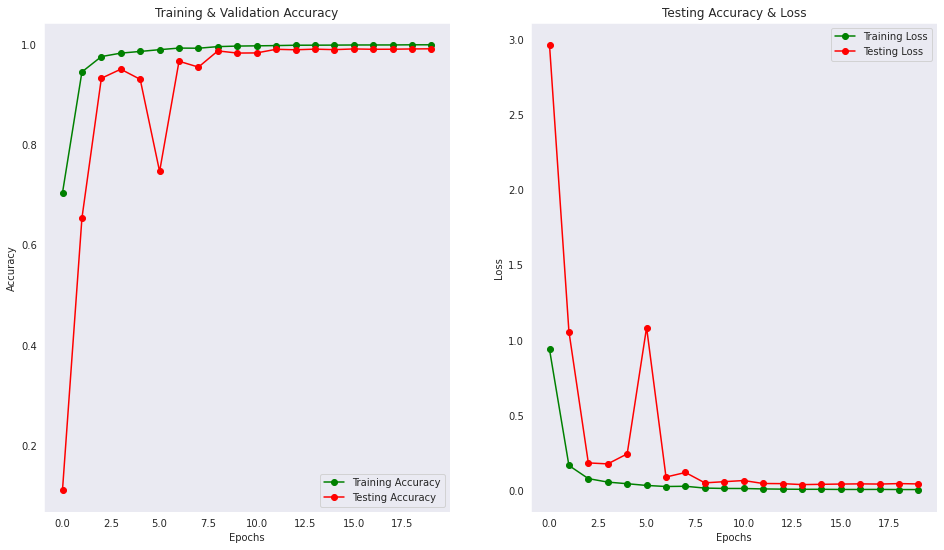

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history7.history['accuracy']
train_loss = history7.history['loss']
val_acc = history7.history['val_accuracy']
val_loss = history7.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

####Conclusion: Redesigning the model
By adding another layer, the performance in terms of validation accuracy was improved. Since the model now consists of a higher number of parameters (see model summary below) due to the added layer, this was expected. 

# **Confusion Matrix**

In order to evaluate how well our model performs, we construct a confusion matrix. 

This is to obtain a summary of prediction results on classification problem. One can observe the number of correct and incorrect predictions with count values and each label is broken down by each label class. 

First, we create a new variable called predictions using the np.argmax function to return the indices of the maximum values and obtain an array of new predicted labels based on our selected best model 7.

In [ ]:

predictions = np.argmax(model7.predict(x_test),axis = 1) 

for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1
        
predictions[:5]

array([ 6,  5, 10,  0,  3])

Next, we applied the function of `label_binarizer.inverse_transform()` to inverse back the labels in y test for inputting into a confusion matrix.

In [ ]:
y_test_inv_label = label_binarizer.inverse_transform(y_test) #Inverse back
y_test_inv_label

array([ 6,  5, 10, ...,  2,  4,  2])

In [ ]:
confusion_matrix(predictions, y_test_inv_label)

array([[331,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 432,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 310,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 245,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 498,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 247,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 346,  10,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

In [ ]:
print("The accuracy from the confusion matrix is - ", accuracy_score(y_test_inv_label, predictions)*100, "%")

The accuracy from the confusion matrix is -  99.13552704963749 %


In [ ]:
#Showing how well the model predicts the different labels/letters

print(classification_report(y_test_inv_label, predictions, target_names=labels))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       1.00      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       0.97      0.99      0.98       348
           H       0.96      0.98      0.97       436
           I       1.00      1.00      1.00       288
           K       1.00      1.00      1.00       331
           L       1.00      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      1.00      1.00       246
           P       1.00      1.00      1.00       347
           Q       0.99      1.00      0.99       164
           R       1.00      1.00      1.00       144
           S       1.00    

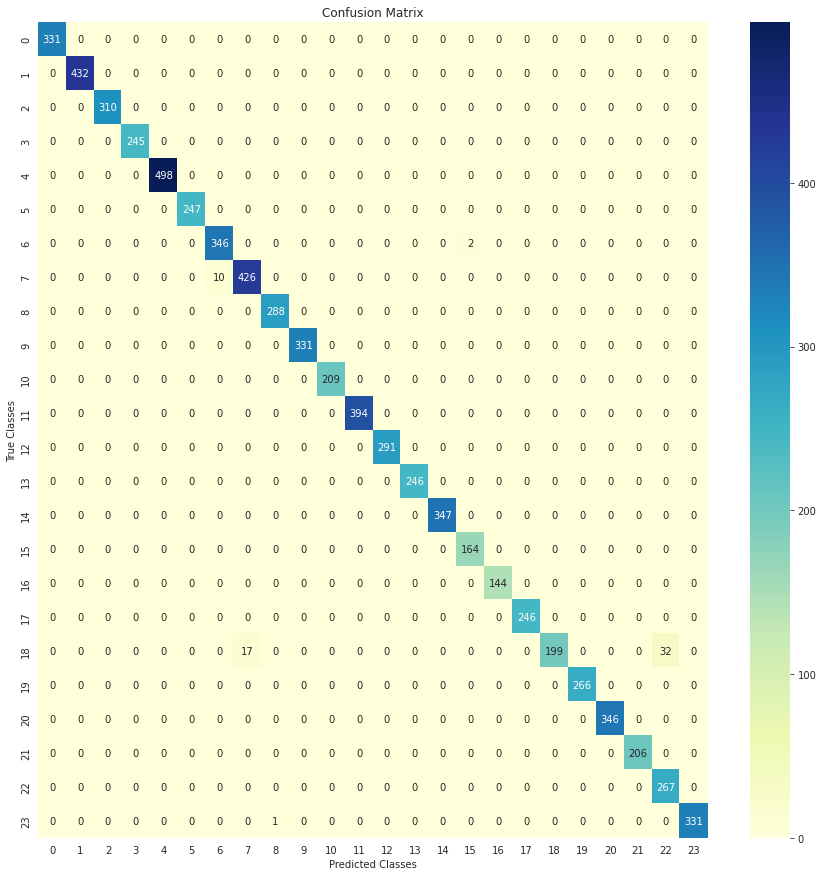

In [ ]:
#Visualizing the confusion matrix 
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test_inv_label, predictions)
plt.figure(figsize = (15,15))
sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt = 'g')
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")
plt.show()

In the confusion matrix above, we can see that each row of the confusion matrix represents the instances of an actual class and each column represents the instances of a predicted class that mostly correct for each label.

##Checking the results

In [ ]:
correct_label = np.nonzero(predictions == y_test_inv_label)[0]
print(correct_label)

[   0    1    2 ... 7169 7170 7171]


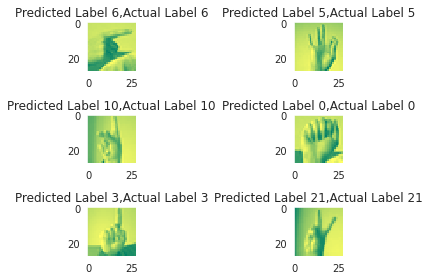

In [ ]:
i = 0
for c in correct_label[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="summer", interpolation='none')
    plt.title("Predicted Label {},Actual Label {}".format(predictions[c], y_test_inv_label[c]))
    plt.tight_layout()
    i += 1

##Conclusion
In this report we have built a convolutional neural network in order to classify letters of the American Sign Language. In the original model that we created we spotted an issue regarding overfitting. The model had a high accuracy when using the training data, but a low accuracy when applying it to the test data. Therefore we chose to try to tweak the model in order to handle the overfitting issue. We have learned that optimization such as Data Augmentation is an important method to increase the accuracy of model performance, as well as applying some callback of ReduceLROnPlateau during the stage of model training.

### Further research
There are a myriad of ways to construct and change convolutional neural networks to create a better test accuracy. In this report, we have only focused on a few. 

In future research, it would be interesting to see how changing the number of filters and hidden layers affect the model. It would also be interesting to use different regularization methods not used here to avoid overfitting. For example, in this case we did not implement the method of early stopping. 
During the stage of model fitting, one can explore further for the callback which can apply EarlyStopping, LambdaCallback, LearningRateScheduler to see whether these can help to improve the model performance or not. Similarly, other optimization methods can be explored further such as using Weight Initialization or Shortcut Connections.

Furthermore, in terms of the number of epochs this is a hyperparameter that one can tune by tuning the model up until a set amount of epochs can be selected and then plot the training as well as the validation loss against the number of epochs. Additionally, one can further analyse this by using early stopping as call back to monitor the number of epochs. 